In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib

PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"
PATIENT = "P1"
PULSES = ["T1", "T2", "SUSC", "T1SIN"]
OUTPUT_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/meningioma"

In [27]:
suf = "_registered_sri24"
suf = ""

data = {}
for pulse in PULSES:
    file = os.path.join(PATH, PATIENT, f"{pulse}_1"+suf+".nii.gz")
    seg = os.path.join(PATH, PATIENT, f"{pulse}_1_seg"+suf+".nii.gz")
    img = nib.load(file)
    seg = nib.load(seg)

    data[pulse] = {
        "vol_path": file,
        "seg_path": seg,
        "vol": img.get_fdata(),
        "seg": seg.get_fdata(),
    }

In [9]:
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction
import SimpleITK as sitk
import numpy as np

# Step 1: Perform brain extraction on T1 sequence
t1_volume = sitk.ReadImage(data["T1"]["vol_path"])
t1_brain_sitk, t1_mask_sitk = fsl_bet_brain_extraction(input_image_sitk=t1_volume, verbose=True)

# Convert T1 mask to numpy array for later use
t1_mask = sitk.GetArrayFromImage(t1_mask_sitk)

# Store the extracted brain for T1
data["T1"]["brain"] = sitk.GetArrayFromImage(t1_brain_sitk)
data["T1"]["brain_mask"] = t1_mask

# Step 2: Apply the T1 mask to all other pulse sequences
for pulse in PULSES:
    if pulse == "T1":
        continue  # Already processed
        
    # Read the volume for this pulse
    volume = sitk.ReadImage(data[pulse]["vol_path"])
    volume_array = sitk.GetArrayFromImage(volume)
    
    # Apply the T1 mask to extract the brain region
    # Ensure the arrays are the same shape
    if volume_array.shape == t1_mask.shape:
        # Extract brain by masking
        brain_array = np.multiply(volume_array, t1_mask)
        
        # Store results in data dictionary
        data[pulse]["brain"] = brain_array
        data[pulse]["brain_mask"] = t1_mask
    else:
        print(f"Warning: Shape mismatch between {pulse} ({volume_array.shape}) and T1 mask ({t1_mask.shape})")
        # You could add resampling here if needed

[FSL BET] Running BET with frac=0.5, robust=False, vertical_gradient=0.0, skull=False
[FSL BET] Completed. Outputs:

inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /tmp/tmpgw46nuxc/bet_out_mask.nii.gz
meshfile = <undefined>
out_file = /tmp/tmpgw46nuxc/bet_out.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>



In [ ]:
for pulse in data.keys():
    print(f"{pulse}: {data[pulse]['vol'].shape} {data[pulse]['seg'].shape} ") #{data[pulse]['brain'].shape}

T1: (240, 240, 155) (240, 240, 155) 
T2: (240, 240, 155) (240, 240, 155) 
SUSC: (240, 240, 155) (240, 240, 155) 
T1SIN: (240, 240, 155) (240, 240, 155) 


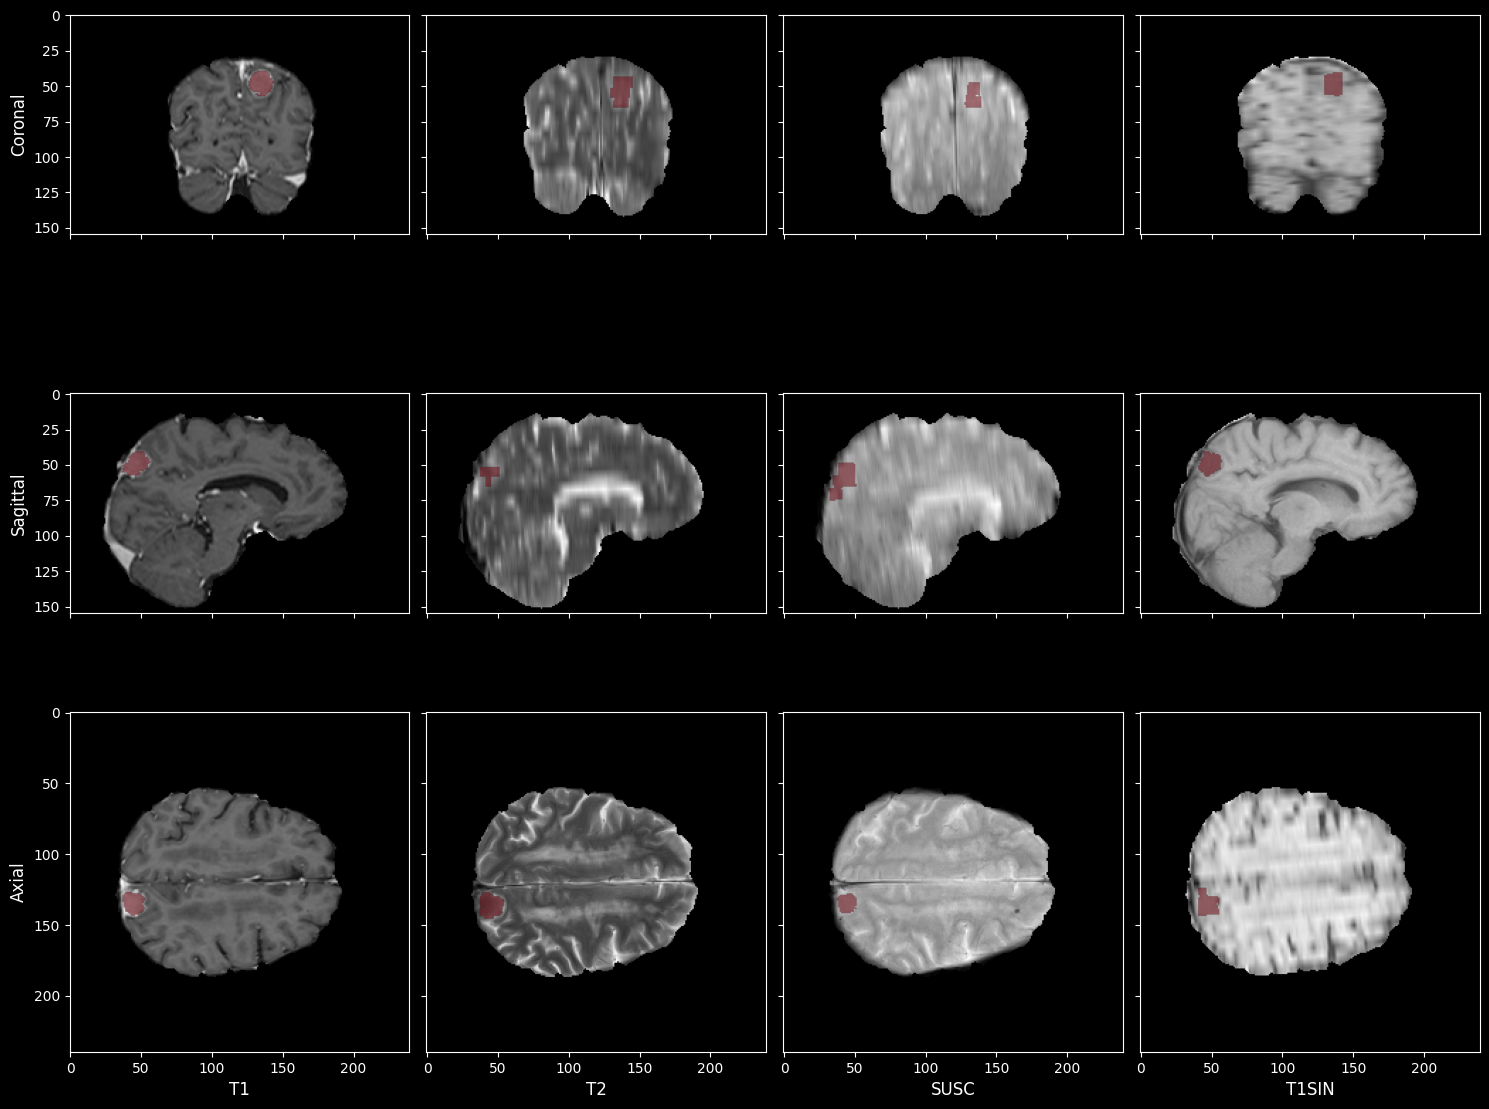

In [28]:
# Visualize data with pulses as columns and views as rows in specific order
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
# Don't call plt.subplots_adjust here - we'll do it after tight_layout
fig.patch.set_facecolor('black')

# Define specific slice indices
sagittal_slice = 100
coronal_slice = 50
axial_slice = 130
# Row titles (now in specific order: coronal, axial, sagittal)
view_titles = ["Coronal", "Sagittal", "Axial"]

# Display each pulse in columns
for col, pulse in enumerate(PULSES):
    vol = data[pulse]["vol"]
    seg = data[pulse]["seg"]

    # Coronal view (top row)
    axes[0, col].imshow(np.rot90(vol[:, coronal_slice]), cmap='gray')
    axes[0, col].imshow(np.rot90(np.ma.where(seg[:, coronal_slice] == 1, 1, np.nan)), cmap='Reds_r', alpha=0.5)
    axes[0, col].axis('on')
    axes[0, col].tick_params(axis='both', colors='white')
    for spine in axes[0, col].spines.values():
        spine.set_color('white')
    
    # Axial view (middle row)
    axes[1, col].imshow(np.rot90(vol[axial_slice]), cmap='gray')
    axes[1, col].imshow(np.rot90(np.ma.where(seg[axial_slice] == 1, 1, np.nan)), cmap='Reds_r', alpha=0.5)
    axes[1, col].axis('on')
    axes[1, col].tick_params(axis='both', colors='white')
    for spine in axes[1, col].spines.values():
        spine.set_color('white')
    
    # Sagittal view (bottom row)
    axes[2, col].imshow(vol[:, :, sagittal_slice], cmap='gray')
    axes[2, col].imshow(np.ma.where(seg[:, :, sagittal_slice] == 1, 1, np.nan), cmap='Reds_r', alpha=0.5)
    axes[2, col].axis('on')
    axes[2, col].tick_params(axis='both', colors='white')
    for spine in axes[2, col].spines.values():
        spine.set_color('white')
    
    # Hide all labels except for the first column (y-axis) and bottom row (x-axis)
    if col != 0:  # Not the first column
        axes[0, col].set_ylabel('')
        axes[0, col].set_yticklabels([])
        axes[1, col].set_ylabel('')
        axes[1, col].set_yticklabels([])
        axes[2, col].set_ylabel('')
        axes[2, col].set_yticklabels([])
    
    # Hide x-axis labels for non-bottom rows
    axes[0, col].set_xlabel('')
    axes[0, col].set_xticklabels([])
    axes[1, col].set_xlabel('')
    axes[1, col].set_xticklabels([])

# Add view labels only to first column (y-axis)
for row, title in enumerate(view_titles):
    axes[row, 0].set_ylabel(title, color='white', fontsize=12, rotation=90)

# Add pulse labels only to bottom row (x-axis)
for col, pulse in enumerate(PULSES):
    axes[2, col].set_xlabel(pulse, color='white', fontsize=12)

plt.tight_layout()
# Apply subplots_adjust AFTER tight_layout
plt.subplots_adjust(wspace=0.05, hspace=0.01)

plt.savefig(os.path.join(OUTPUT_PATH, PATIENT, f"visualization_revised_P{PATIENT}.png"), 
            facecolor='black', bbox_inches='tight', dpi=150)
plt.show()

try tc

Applying window with width=80, level=40
  After windowing - Min: 0.0000, Max: 1.0000
[ANTS REGISTRATION] Moving image size: (271, 512, 512)
[ANTS REGISTRATION] Fixed image size: (240, 240, 155)
[ANTS REGISTRATION] Output directory: /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/temp_dir_registration
[ANTS REGISTRATION] Output registered image: /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/temp_dir_registration/registered.nii.gz
[ANTS REGISTRATION] Mask image size: (271, 512, 512)
[ANTS REGISTRATION] Output registered mask: /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/temp_dir_registration/registered_mask.nii.gz
[ANTS REGISTRATION] Performing registration with mask...
[ANTS REGISTRATION] Creating output directory for entire process
[ANTS REGISTRATION] Output directory path: /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/temp_dir_registration
[ANTS REGISTRATION] Saved input mask to: /home/mariopasc/Python/Datasets/Meningiomas/ATLAS/temp_dir_registration/moving_mask_input.n

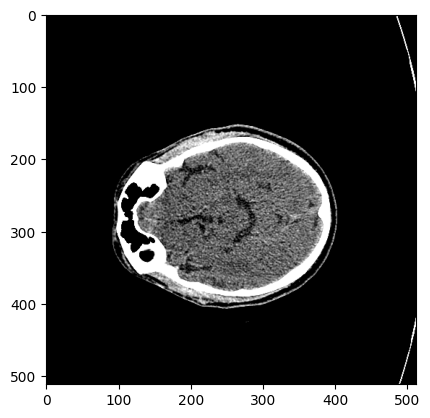

In [ ]:
import nrrd

from Meningioma.external.surfa.docs import conf
from Meningioma.preprocessing.tools.remove_extra_channels import remove_first_channel
from Meningioma.preprocessing.tools.nrrd_to_nifti import nifti_write_3d
from Meningioma.preprocessing.tools.casting import cast_volume_and_mask
from Meningioma.preprocessing.tools.hu_window import apply_window
from Meningioma.preprocessing.tools.skull_stripping.fsl_bet import fsl_bet_brain_extraction
from Meningioma.preprocessing.tools.registration.ants_registration import register_image_to_sri24

TC_PATH = "/home/mariopasc/Python/Datasets/Meningiomas/Meningioma_Adquisition/TC/P1"

OUT = "/home/mariopasc/Python/Datasets/Meningiomas"

tc_image, hdr = nrrd.read(os.path.join(TC_PATH, "TC_P1.nrrd"))
mask, hdr = nrrd.read(os.path.join(TC_PATH, "TC_P1_seg.nrrd"))
tc_image = apply_window(sitk.GetImageFromArray(tc_image), 
                        window_level=40, 
                        window_width=80, verbose=True)

tc_image_registered, mask, transforms = register_image_to_sri24(moving_image=tc_image, moving_mask=sitk.GetImageFromArray(mask), 
                                   config_path="/home/mariopasc/Python/Projects/Meningioma/src/Meningioma/preprocessing/configs/registration_sri24.yaml",
                                   verbose=True)

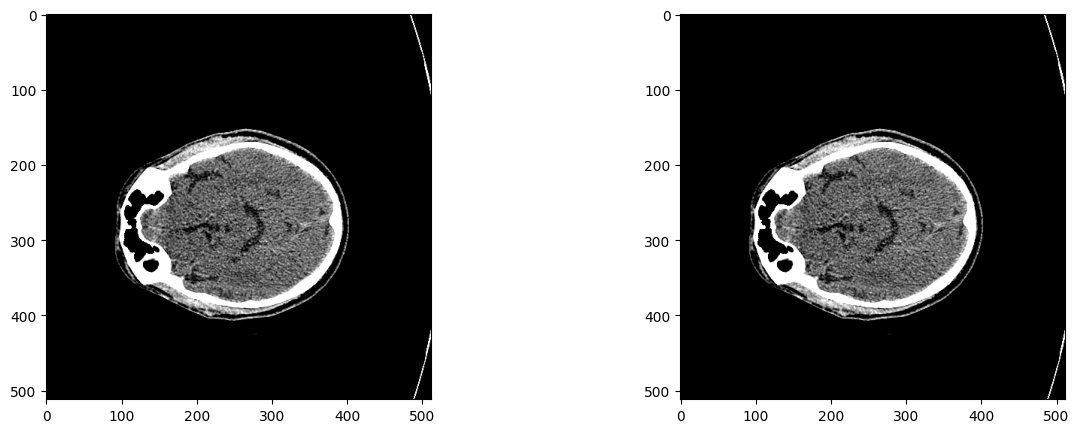

In [ ]:
import matplotlib.pyplot as plt

original_array = sitk.GetArrayFromImage(tc_image)
registered_array = sitk.GetArrayFromImage(tc_image_registered)

_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(array[:, :, 100], cmap='gray')
axes[1].imshow(array[:, :, 100], cmap='gray')